## 1. Import Libraries

In [3]:
! pip install split-folders scikit-learn tensorflow matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import time
import zipfile
import tensorflow as tf
import imutils
import splitfolders
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 2. Extract Dataset

In [ ]:
zip_file = "/content/archive.zip"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("Brain Tumor Dataset")

## 3. Exploratory Data Analysis (EDA)

In [12]:
base_path = r"D:\Training"

tumor_types = ["glioma", "meningioma", "notumor", "pituitary"]

def count_files(base_path):
    for tumor_type in tumor_types:
        folder_path = os.path.join(base_path, tumor_type)
        if os.path.exists(folder_path):
            file_list = os.listdir(folder_path)
            print(f"Number of files in {tumor_type}: {len(file_list)}")
        else:
            print(f"{tumor_type} folder not found!")

print("Brain Tumor MRI Dataset EDA")
count_files(base_path)

Brain Tumor MRI Dataset EDA
Number of files in glioma: 1351
Number of files in meningioma: 1359
Number of files in notumor: 1625
Number of files in pituitary: 1457


## 4. Augment Data

In [14]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int(sec_elapsed % (60 * 60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

def augmented_data(base_dir, n_generated_samples, save_base_dir):
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    start_time = time.time()

    for tumor_type in tumor_types:
        source_dir = os.path.join(base_dir, tumor_type)
        save_dir = os.path.join(save_base_dir, tumor_type)
        os.makedirs(save_dir, exist_ok=True)

        for filename in os.listdir(source_dir):
            image = cv2.imread(os.path.join(source_dir, filename))
            image = image.reshape((1,) + image.shape)
            save_prefix = 'aug_' + filename[:-4]
            i = 0

            for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_dir, save_prefix=save_prefix, save_format="jpg"):
                i += 1
                if i >= n_generated_samples:
                    break

    end_time = time.time()
    print(f"Data augmentation completed in: {timing(end_time - start_time)}")

bbase_dir = r'D:\Training'
n_generated_samples = 5
save_base_dir = r'D:\Augmented Data'
augmented_data(base_dir, n_generated_samples, save_base_dir)


Data augmentation completed in: 0:11:59.09842324256897


## 5. Rename Files

In [16]:
def rename_files(folder, tumor_name):
    count = 1
    for filename in os.listdir(folder):
        source = os.path.join(folder, filename)
        destination = os.path.join(folder, f"{tumor_name}_{count}.jpg")
        os.rename(source, destination)
        count += 1
    print(f"{tumor_name} Tumor Images Renamed Successfully.")

for tumor in tumor_types:
    folder = f'D:\Augmented Data/{tumor}/'
    rename_files(folder, tumor)

<>:11: SyntaxWarning: invalid escape sequence '\A'
<>:11: SyntaxWarning: invalid escape sequence '\A'
C:\Users\gamer\AppData\Local\Temp\ipykernel_13244\3876313277.py:11: SyntaxWarning: invalid escape sequence '\A'
  folder = f'D:\Augmented Data/{tumor}/'


glioma Tumor Images Renamed Successfully.
meningioma Tumor Images Renamed Successfully.
notumor Tumor Images Renamed Successfully.
pituitary Tumor Images Renamed Successfully.


## 6. Visualize Dataset

Tumor type counts (Augmented Data): [14625, 13585, 8124, 7284]


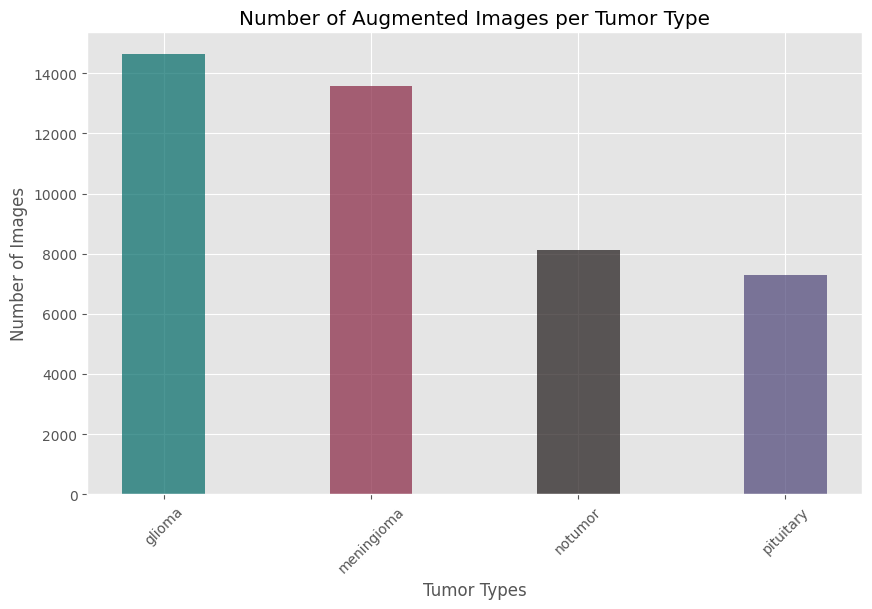

In [18]:
tumor_counts = [len(os.listdir(os.path.join(save_base_dir, tumor))) for tumor in tumor_types]
print("Tumor type counts (Augmented Data):", tumor_counts)

colors = ['#006A67', '#872341', '#1D1616', '#4B4376']
x = np.arange(len(tumor_types))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x, tumor_counts, width=width, align='center', alpha=0.7, color=colors)
plt.xlabel('Tumor Types')
plt.ylabel('Number of Images')
plt.title('Number of Augmented Images per Tumor Type')
plt.xticks(x, tumor_types, rotation=45)
plt.show()

## 7. Crop Brain Tumor (Remove Black Parts)

In [19]:
def crop_brain_tumor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations=2)
    thres = cv2.dilate(thres, None, iterations=2)
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        return image

    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    cropped_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    return cropped_image

def crop_and_save_images(folder_path):
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        if image is not None:
            cropped_image = crop_brain_tumor(image)
            cv2.imwrite(image_path, cropped_image)
            print(f"Processed: {filename}")
        else:
            print(f"Failed to read: {filename}")

for tumor in tumor_types:
    folder_path = os.path.join(save_base_dir, tumor)
    print(f"Processing folder: {folder_path}")
    crop_and_save_images(folder_path)

Processing folder: D:\Augmented Data\glioma
Processed: glioma_1.jpg
Processed: glioma_10.jpg
Processed: glioma_100.jpg
Processed: glioma_1000.jpg
Processed: glioma_10000.jpg
Processed: glioma_10001.jpg
Processed: glioma_10002.jpg
Processed: glioma_10003.jpg
Processed: glioma_10004.jpg
Processed: glioma_10005.jpg
Processed: glioma_10006.jpg
Processed: glioma_10007.jpg
Processed: glioma_10008.jpg
Processed: glioma_10009.jpg
Processed: glioma_1001.jpg
Processed: glioma_10010.jpg
Processed: glioma_10011.jpg
Processed: glioma_10012.jpg
Processed: glioma_10013.jpg
Processed: glioma_10014.jpg
Processed: glioma_10015.jpg
Processed: glioma_10016.jpg
Processed: glioma_10017.jpg
Processed: glioma_10018.jpg
Processed: glioma_10019.jpg
Processed: glioma_1002.jpg
Processed: glioma_10020.jpg
Processed: glioma_10021.jpg
Processed: glioma_10022.jpg
Processed: glioma_10023.jpg
Processed: glioma_10024.jpg
Processed: glioma_10025.jpg
Processed: glioma_10026.jpg
Processed: glioma_10027.jpg
Processed: gliom

## 8. Split Data

In [24]:
input_folder = r"D:\Augmented Data"
output_folder = r"D:\Split Data"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))
print("Dataset successfully split into training, validation, and test sets.")

Dataset successfully split into training, validation, and test sets.


In [27]:
import shutil

# Create a zip archive of the 'Split Data' directory
shutil.make_archive('Split_Data', 'zip', 'Split Data')

print("Zip file created: Split_Data.zip")



FileNotFoundError: [WinError 2] The system cannot find the file specified: 'Split Data'

## 9. Build CNN Model

In [28]:
def build_cnn_model():
    model = Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 10. Prepare Data Generators

In [31]:
train_dir = r"D:\Split Data\train"
val_dir = r"D:\Split Data\val"
test_dir = r"D:\Split Data\test"


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

Found 34894 images belonging to 4 classes.
Found 4360 images belonging to 4 classes.
Found 4364 images belonging to 4 classes.


## 11. Train the Model

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

c:\Users\gamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.5856 - loss: 0.9467

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 320s 293ms/step - accuracy: 0.5857 - loss: 0.9465 - val_accuracy: 0.8204 - val_loss: 0.4655
Epoch 2/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8049 - loss: 0.4973

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 144s 132ms/step - accuracy: 0.8049 - loss: 0.4973 - val_accuracy: 0.8819 - val_loss: 0.3005
Epoch 3/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8701 - loss: 0.3536

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 139s 128ms/step - accuracy: 0.8701 - loss: 0.3535 - val_accuracy: 0.8906 - val_loss: 0.2884
Epoch 4/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9032 - loss: 0.2669

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 138s 127ms/step - accuracy: 0.9032 - loss: 0.2669 - val_accuracy: 0.9514 - val_loss: 0.1439
Epoch 5/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9188 - loss: 0.2230

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 143s 131ms/step - accuracy: 0.9188 - loss: 0.2230 - val_accuracy: 0.9466 - val_loss: 0.1379
Epoch 6/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9299 - loss: 0.2020

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 154s 141ms/step - accuracy: 0.9299 - loss: 0.2020 - val_accuracy: 0.9534 - val_loss: 0.1302
Epoch 7/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9415 - loss: 0.1635

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 157s 144ms/step - accuracy: 0.9415 - loss: 0.1635 - val_accuracy: 0.9592 - val_loss: 0.1236
Epoch 8/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 157s 144ms/step - accuracy: 0.9464 - loss: 0.1492 - val_accuracy: 0.9509 - val_loss: 0.1809
Epoch 9/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9486 - loss: 0.1522

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 157s 144ms/step - accuracy: 0.9486 - loss: 0.1522 - val_accuracy: 0.9709 - val_loss: 0.0923
Epoch 10/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9546 - loss: 0.1356

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 145s 133ms/step - accuracy: 0.9546 - loss: 0.1356 - val_accuracy: 0.9778 - val_loss: 0.0637
Epoch 11/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 141s 129ms/step - accuracy: 0.9597 - loss: 0.1158 - val_accuracy: 0.9780 - val_loss: 0.0659
Epoch 12/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 141s 129ms/step - accuracy: 0.9593 - loss: 0.1137 - val_accuracy: 0.9693 - val_loss: 0.0896
Epoch 13/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 141s 129ms/step - accuracy: 0.9610 - loss: 0.1110 - val_accuracy: 0.9647 - val_loss: 0.1162
Epoch 14/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 141s 129ms/step - accuracy: 0.9612 - loss: 0.1138 - val_accuracy: 0.9764 - val_loss: 0.0817
Epoch 15/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9628 - loss: 0.1061

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 141s 129ms/step - accuracy: 0.9628 - loss: 0.1061 - val_accuracy: 0.9828 - val_loss: 0.0489
Epoch 16/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 139s 128ms/step - accuracy: 0.9661 - loss: 0.0980 - val_accuracy: 0.9812 - val_loss: 0.0648
Epoch 17/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 140s 128ms/step - accuracy: 0.9680 - loss: 0.0948 - val_accuracy: 0.9810 - val_loss: 0.0758
Epoch 18/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 140s 129ms/step - accuracy: 0.9687 - loss: 0.0929 - val_accuracy: 0.9796 - val_loss: 0.0659
Epoch 19/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 140s 128ms/step - accuracy: 0.9712 - loss: 0.0848 - val_accuracy: 0.9771 - val_loss: 0.0683
Epoch 20/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 141s 129ms/step - accuracy: 0.9689 - loss: 0.0894 - val_accuracy: 0.9846 - val_loss: 0.0554


## 12. Evaluate on Test Set

In [34]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")

137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9800 - loss: 0.0552
Test Accuracy: 98.21%


## 13. Accuracy Chart

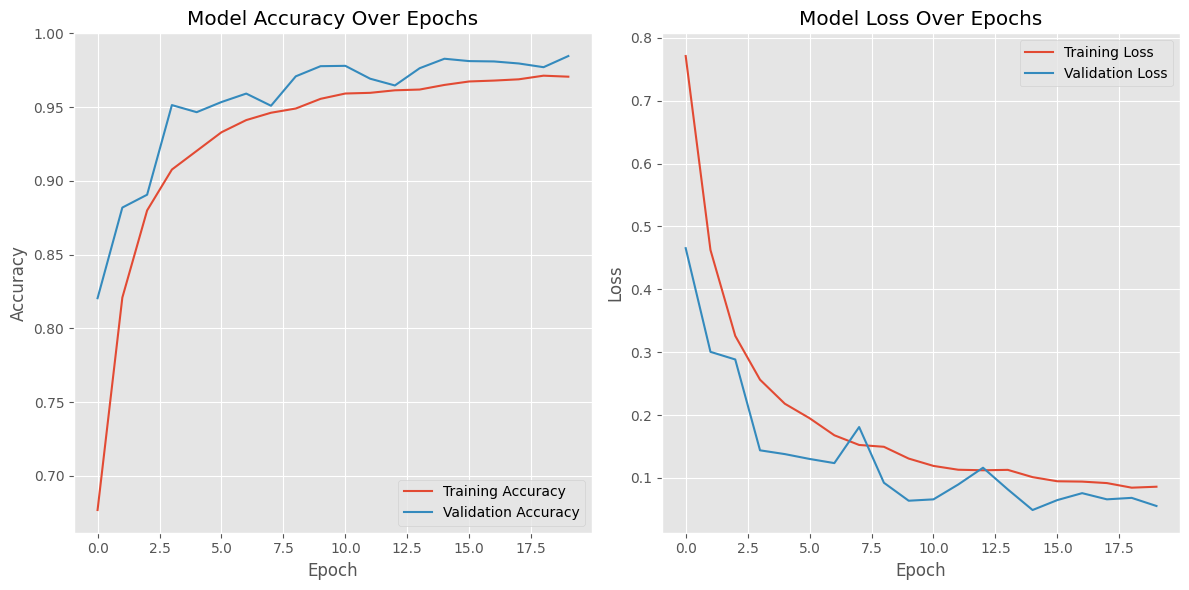

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 14. Testing

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('/content/best_model.h5')
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img, img_array

def predict_image(img_path):
    img, img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"Predicted Tumor Type: {class_names[predicted_class[0]]}")

img_path = '/content/Split Data/test/pituitary_tumor/pituitary_tumor_1040.jpg'
predict_image(img_path)


<>:6: SyntaxWarning: invalid escape sequence '\V'
<>:25: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\V'
<>:25: SyntaxWarning: invalid escape sequence '\S'
C:\Users\gamer\AppData\Local\Temp\ipykernel_13244\1225450435.py:6: SyntaxWarning: invalid escape sequence '\V'
  model = tf.keras.models.load_model('F:\VS progs\Flemingo-Brain-Tumor-Detection-Project-main')
C:\Users\gamer\AppData\Local\Temp\ipykernel_13244\1225450435.py:25: SyntaxWarning: invalid escape sequence '\S'
  img_path = "D:\Split Data\test\pituitary\pituitary_158.jpg"
C:\Users\gamer\AppData\Local\Temp\ipykernel_13244\1225450435.py:6: SyntaxWarning: invalid escape sequence '\V'
  model = tf.keras.models.load_model('F:\VS progs\Flemingo-Brain-Tumor-Detection-Project-main')
C:\Users\gamer\AppData\Local\Temp\ipykernel_13244\1225450435.py:25: SyntaxWarning: invalid escape sequence '\S'
  img_path = "D:\Split Data\test\pituitary\pituitary_158.jpg"


ValueError: File format not supported: filepath=F:\VS progs\Flemingo-Brain-Tumor-Detection-Project-main. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(F:\VS progs\Flemingo-Brain-Tumor-Detection-Project-main, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).